In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


In [3]:
adata_pb = sc.read('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/pb_adata_MG_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 292 × 29040
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

# Identify outliers

In [4]:
adata_pb.obs['cell_stim'] = adata_pb.obs['cell_type'].astype(str) + '_' + adata_pb.obs['stim'].astype(str)

In [5]:
# Extract the log_lib_size column
log_lib_size = adata_pb.obs['log_lib_size']

# Compute the median
median = np.median(log_lib_size)

# Compute the MAD (Median Absolute Deviation)
mad = np.median(np.abs(log_lib_size - median))

# Define the upper and lower thresholds
upper_threshold = median + 3 * mad
lower_threshold = median - 3 * mad

# Find outliers
outliers = adata_pb.obs[(log_lib_size < lower_threshold)]

# Print the results
print(f"Median: {median}, MAD: {mad}")
print(f"Lower threshold: {lower_threshold}")
print(f"Outliers:\n{outliers}")

Median: 12.186070736808462, MAD: 0.8403393485043571
Lower threshold: 9.66505269129539
Outliers:
                                            sample       sample_lesion  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  Ind120-Sample1  Ind120-Sample1_CAL   
donor_Ind143-Sample1_0-1-0-0        Ind143-Sample1   Ind143-Sample1_AL   

                                   diagnosis sample_source cell_type  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      SPMS  Amsterdam BB      Mg_A   
donor_Ind143-Sample1_0-1-0-0            PPMS  Amsterdam BB      Mg_E   

                                   sample_rep replicate_cat stim sex seq_pool  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      CAL_5             5  CAL   M   Pool 1   
donor_Ind143-Sample1_0-1-0-0            AL_20            20   AL   M   Pool 1   

                                   age_scale   age_cat    pmi_cat   pmi_cat2  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  0.713744   over_70  6H_to_12H  up_to_12H   
donor_Ind143-Sample1_0-1-0-0       -1.141343  under_50  6H_t

In [6]:
# Compute the max and min log_lib_size
max_log_lib_size = log_lib_size.max()
min_log_lib_size = log_lib_size.min()

print(f"Maximum log_lib_size: {max_log_lib_size}")
print(f"Minimum log_lib_size: {min_log_lib_size}")

Maximum log_lib_size: 15.242901515897758
Minimum log_lib_size: 9.490620114661201


In [7]:
print(f"All samples: {adata_pb.shape[0]}")

All samples: 292


In [8]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
Mg_A,13,7,5,8,5,9
Mg_B,12,7,10,12,9,11
Mg_C,13,11,8,9,7,6
Mg_D,11,7,4,7,3,0
Mg_E,14,13,8,7,4,2
Mg_F,6,7,5,7,5,4
Mg_G,5,3,2,2,4,0


In [9]:
# Define the list of samples to remove
samples_to_remove = [
    "donor_Ind120-Sample1_0-0-0-0-0-0-0",
    "donor_Ind143-Sample1_0-1-0-0"
]

# Filter out the samples to remove
adata_pb = adata_pb[~adata_pb.obs.index.isin(samples_to_remove)].copy()

# Confirm removal
print(f"Remaining samples: {adata_pb.shape[0]}")

Remaining samples: 290


# Subset to relevant comparison 

In [10]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
Mg_A,13,6,5,8,5,9
Mg_B,12,7,10,12,9,11
Mg_C,13,11,8,9,7,6
Mg_D,11,7,4,7,3,0
Mg_E,13,13,8,7,4,2
Mg_F,6,7,5,7,5,4
Mg_G,5,3,2,2,4,0


In [11]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'Mg_E'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (93, 29040)


In [12]:
adata_sub.obs

,sample,sample_lesion,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim
donor_Ind98-Sample2_0-0-0-0-0-0-0,Ind98-Sample2,Ind98-Sample2_WM,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM
donor_Ind102-Sample1_0-0-0-0-0-0-0,Ind102-Sample1,Ind102-Sample1_AL,SPMS,Amsterdam BB,Mg_A,AL_1,1,AL,M,Pool 4,0.301502,inbetween,6H_to_12H,up_to_12H,0,66310,11.102096,Mg_A_AL
donor_Ind102-Sample4_0-0-0-0-0-0-0,Ind102-Sample4,Ind102-Sample4_CAL,SPMS,Amsterdam BB,Mg_A,CAL_17,17,CAL,M,Pool 1,0.301502,inbetween,6H_to_12H,up_to_12H,0,40936,10.619765,Mg_A_CAL
donor_Ind103-Sample1_0-0-0-0-0-0-0,Ind103-Sample1,Ind103-Sample1_AL,RRMS,Amsterdam BB,Mg_A,AL_2,2,AL,F,Pool 3,-1.484878,under_50,up_to_6H,up_to_12H,0,143763,11.875921,Mg_A_AL
donor_Ind104-Sample1_0-0-0-0-0-0-0,Ind104-Sample1,Ind104-Sample1_RL,SPMS,UK MS TB,Mg_A,RL_2,2,RL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,35938,10.489551,Mg_A_RL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
donor_Ind136-Sample1_0-1-0-0,Ind136-Sample1,Ind136-Sample1_CAL,PPMS,Amsterdam BB,Mg_E,CAL_14,14,CAL,M,Pool 3,-1.278757,under_50,6H_to_12H,up_to_12H,0,1009382,13.824849,Mg_E_CAL
donor_Ind137-Sample1_0-1-0-0,Ind137-Sample1,Ind137-Sample1_CAL,SPMS,Amsterdam BB,Mg_E,CAL_15,15,CAL,M,Pool 2,-0.935223,under_50,up_to_6H,up_to_12H,0,57144,10.953330,Mg_E_CAL
donor_Ind139-Sample1_0-1-0-0,Ind139-Sample1,Ind139-Sample1_WM,CTR,Amsterdam BB,Mg_E,WM_10,10,WM,M,Pool 1,1.469520,over_70,up_to_6H,up_to_12H,0,163544,12.004837,Mg_E_WM
donor_Ind144-Sample1_0-1-0-0,Ind144-Sample1,Ind144-Sample1_WM,CTR,Amsterdam BB,Mg_E,WM_12,12,WM,M,Pool 1,1.744348,over_70,up_to_6H,up_to_12H,0,155155,11.952180,Mg_E_WM


In [13]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['stim'].unique()
for condition in unique_conditions:
    print(condition)

WM
AL
CAL
RL
CIL
NAWM


In [14]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['stim'], 
                           ['WM',
                              'AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (37, 29040)


In [15]:
# Check if the 'sample_rep' column exists
if 'sample_lesion' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_lesion', inplace=True)
else:
    print("The column 'sample' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [16]:
# Add the index back as a column called 'sample_lesion'
adata_sub.obs['sample_lesion'] = adata_sub.obs.index

In [17]:
adata_sub.obs['indiv_id'] = adata_sub.obs['sample'].str.split('-').str[0]
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM,Ind98-Sample2_WM,Ind98
Ind102-Sample1_AL,Ind102-Sample1,SPMS,Amsterdam BB,Mg_A,AL_1,1,AL,M,Pool 4,0.301502,inbetween,6H_to_12H,up_to_12H,0,66310,11.102096,Mg_A_AL,Ind102-Sample1_AL,Ind102
Ind103-Sample1_AL,Ind103-Sample1,RRMS,Amsterdam BB,Mg_A,AL_2,2,AL,F,Pool 3,-1.484878,under_50,up_to_6H,up_to_12H,0,143763,11.875921,Mg_A_AL,Ind103-Sample1_AL,Ind103
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,Mg_A,WM_3,3,WM,M,Pool 3,-0.935223,under_50,over_12H,over_12H,0,706855,13.468581,Mg_A_WM,Ind107-Sample1_WM,Ind107
Ind113-Sample1_AL,Ind113-Sample1,SPMS,Amsterdam BB,Mg_A,AL_6,6,AL,F,Pool 4,1.125985,over_70,up_to_6H,up_to_12H,0,72946,11.197475,Mg_A_AL,Ind113-Sample1_AL,Ind113


In [18]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_stim', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_stim', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,WM
cell_stim,,
Mg_A_AL,13,0
Mg_A_WM,0,9
Mg_E_AL,13,0
Mg_E_WM,0,2


In [19]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_stim'], 
                           ['Mg_A_WM',
                            'Mg_E_AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (22, 29040)


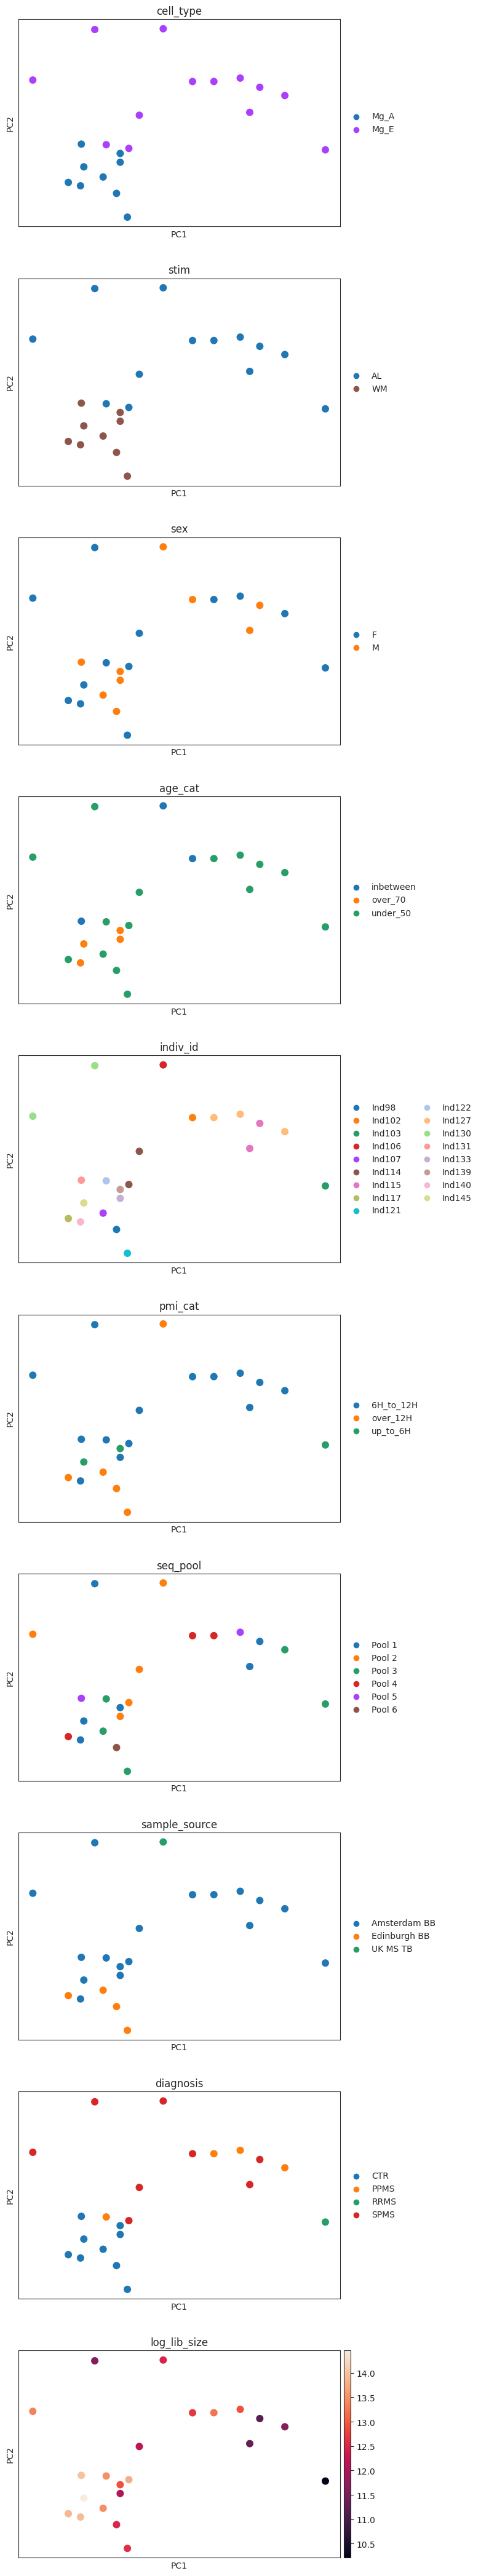

In [20]:
sc.pl.pca(adata_sub, color=["cell_type", "stim", "sex", "age_cat", "indiv_id",
                            "pmi_cat", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], 
          ncols=1, size=300)

In [21]:
# Replace space with underscore in the 'seq_pool' column
adata_sub.obs['seq_pool'] = adata_sub.obs['seq_pool'].str.replace(' ', '_')
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,Mg_A,WM_1,1,WM,M,Pool_6,-1.759706,under_50,over_12H,over_12H,0,268489,12.500565,Mg_A_WM,Ind98-Sample2_WM,Ind98
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,Mg_A,WM_3,3,WM,M,Pool_3,-0.935223,under_50,over_12H,over_12H,0,706855,13.468581,Mg_A_WM,Ind107-Sample1_WM,Ind107
Ind117-Sample1_WM,Ind117-Sample1,CTR,Edinburgh BB,Mg_A,WM_4,4,WM,F,Pool_4,-0.935223,under_50,over_12H,over_12H,0,1079993,13.892465,Mg_A_WM,Ind117-Sample1_WM,Ind117
Ind121-Sample1_WM,Ind121-Sample1,CTR,Edinburgh BB,Mg_A,WM_5,5,WM,F,Pool_3,-0.729102,under_50,over_12H,over_12H,0,297926,12.604600,Mg_A_WM,Ind121-Sample1_WM,Ind121
Ind131-Sample1_WM,Ind131-Sample1,CTR,Amsterdam BB,Mg_A,WM_7,7,WM,M,Pool_5,0.438916,inbetween,6H_to_12H,up_to_12H,0,1178400,13.979668,Mg_A_WM,Ind131-Sample1_WM,Ind131


In [22]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 2  1  0  0  6]
 [12  0  0  0 40]
 [ 7  0  0  0 41]
 [ 2  0  0  0 10]
 [ 4  0  1  0 23]]


In [23]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,WM
cell_type,,
Mg_A,0,9
Mg_E,13,0


# Start R code: QC of log transformation

In [24]:
for col in adata_sub.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_sub.obs[col]):
        adata_sub.obs[col] = adata_sub.obs[col].astype(str)

In [25]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$stim #ctrl or stim
replicate <- colData(adata_sub)$replicate_cat #replicate number
batch <- colData(adata_sub)$sample_lesion #this is each indiv sample

# Concatenate label and cell type for group factor
sex <- colData(adata_sub)$sex #ctrl or stim
age_cat <- colData(adata_sub)$age_cat #replicate number
pmi_cat <- colData(adata_sub)$pmi_cat #this is each indiv sample
pmi_cat2 <- colData(adata_sub)$pmi_cat2 #replicate number
seq_pool <- colData(adata_sub)$seq_pool #this is each indiv sample

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"=batch,
                        "Sex"=sex, "Age_cat"=age_cat, "Pmi_cat"=pmi_cat, "Pmi_cat2"=pmi_cat2,
                        "Seq_pool"=seq_pool)
head(treatments)

                  Group Reps             Batch Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM    1  Ind98-Sample2_WM   M  under_50  over_12H
Ind107-Sample1_WM    WM    3 Ind107-Sample1_WM   M  under_50  over_12H
Ind117-Sample1_WM    WM    4 Ind117-Sample1_WM   F  under_50  over_12H
Ind121-Sample1_WM    WM    5 Ind121-Sample1_WM   F  under_50  over_12H
Ind131-Sample1_WM    WM    7 Ind131-Sample1_WM   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM    8 Ind133-Sample1_WM   M   over_70 6H_to_12H
                   Pmi_cat2 Seq_pool
Ind98-Sample2_WM   over_12H   Pool_6
Ind107-Sample1_WM  over_12H   Pool_3
Ind117-Sample1_WM  over_12H   Pool_4
Ind121-Sample1_WM  over_12H   Pool_3
Ind131-Sample1_WM up_to_12H   Pool_5
Ind133-Sample1_WM up_to_12H   Pool_2


In [26]:
%%R -i adata_sub

# Create the treatments dataframe with samples as a column, not as row names
treatments <- data.frame(
  #Sample = colData(adata_sub)$sample,      # Sample column
  Group = colData(adata_sub)$stim,        # Group (e.g., ctrl or stim)
  Donor = colData(adata_sub)$indiv_id,    # Donor information
  Sex = colData(adata_sub)$sex,           # Sex information
  Age_cat = colData(adata_sub)$age_cat,   # Age category
  Pmi_cat = colData(adata_sub)$pmi_cat   # Post-mortem interval category
)

# Check the updated dataframe to confirm
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [27]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$stim)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 29040    22

AL WM 
13  9 


In [28]:
%%R

# Adjust for batch-- ie publication in the model matrix
design_full <- model.matrix(~0 + Group + Sex + Age_cat + Pmi_cat, data=treatments)
rownames(design_full) <- colnames(x)
colnames(design_full)

[1] "GroupAL"         "GroupWM"         "SexM"            "Age_catover_70" 
[5] "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [29]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design_full)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 8897   22


In [30]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 10571    22


In [31]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.0012167 0.9770843 1.0311171 1.0277589 0.9697245 1.0105747 0.9874821
 [8] 1.0382444 0.9885527 0.9018511 1.3762683 0.9471476 0.9351543 1.0497514
[15] 1.0498182 1.0177531 1.1072855 0.9087080 0.8051361 0.7783850 1.1538055
[22] 1.0825126


In [32]:
%%R
cd <- x2$samples$group
print(cd)

 [1] WM WM WM WM WM WM WM WM WM AL AL AL AL AL AL AL AL AL AL AL AL AL
Levels: AL WM


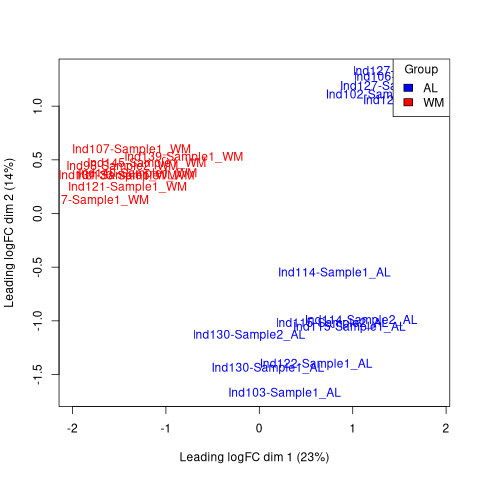

In [33]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

# Voom with quality weights- sex, age, pmi, seq_pool

In [34]:
%%R
donor <- colData(adata_sub)$indiv_id #this is each indiv sample
donor

 Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM Ind121-Sample1_WM 
          "Ind98"          "Ind107"          "Ind117"          "Ind121" 
Ind131-Sample1_WM Ind133-Sample1_WM Ind139-Sample1_WM Ind140-Sample1_WM 
         "Ind131"          "Ind133"          "Ind139"          "Ind140" 
Ind145-Sample1_WM Ind102-Sample1_AL Ind103-Sample1_AL Ind106-Sample1_AL 
         "Ind145"          "Ind102"          "Ind103"          "Ind106" 
Ind114-Sample1_AL Ind114-Sample2_AL Ind115-Sample1_AL Ind115-Sample2_AL 
         "Ind114"          "Ind114"          "Ind115"          "Ind115" 
Ind122-Sample1_AL Ind127-Sample1_AL Ind127-Sample3_AL Ind127-Sample4_AL 
         "Ind122"          "Ind127"          "Ind127"          "Ind127" 
Ind130-Sample1_AL Ind130-Sample2_AL 
         "Ind130"          "Ind130" 


In [35]:
%%R
head(design_full)

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
                  Pmi_catover_12H Pmi_catup_to_6H
Ind98-Sample2_WM                1               0
Ind107-Sample1_WM               1               0
Ind117-Sample1_WM               1               0
Ind121-Sample1_WM               1               0
Ind131-Sample1_WM               0               0
Ind133-Sample1_WM               0               0


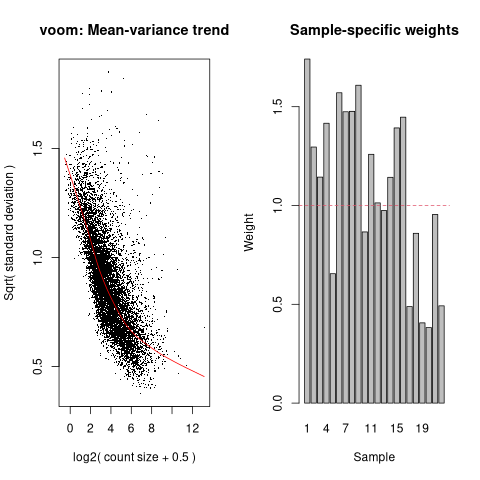

In [36]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE)

In [37]:
%%R

corfit <- duplicateCorrelation(y_vqw_full, design_full, block=donor)
corfit$consensus.correlation

[1] 0.5026689


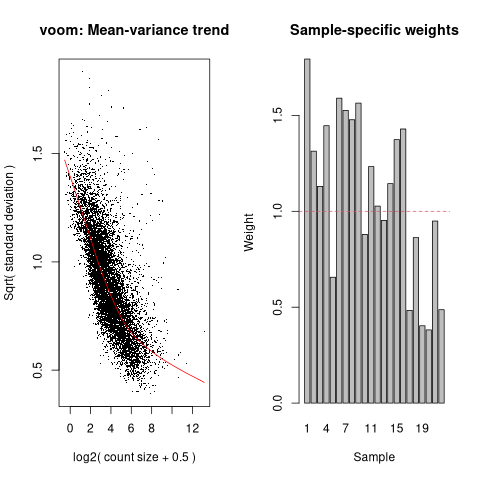

In [38]:
%%R

y2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor, correlation=corfit$consensus)

In [39]:
%%R

corfit2 <- duplicateCorrelation(y2, design_full, block=donor)
corfit2$consensus.correlation

[1] 0.5027884


In [40]:
%%R

fit <- lmFit(y2, design_full, block=donor, correlation=corfit2$consensus)

In [41]:
%%R

contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

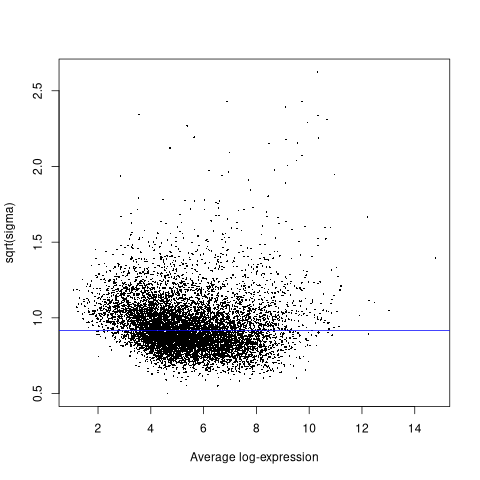

In [42]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [43]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

               logFC   AveExpr         t      P.Value    adj.P.Val        B
ST6GALNAC3 -4.179549  9.301374 -13.87436 2.048924e-12 1.220784e-08 18.55944
NAV3       -3.619015  9.693441 -13.67270 2.744259e-12 1.220784e-08 18.26226
SERPINB9   -3.667594  6.308777 -12.16044 2.754428e-11 8.168715e-08 15.80128
AC008691.1 -6.166237  7.592861 -11.55120 7.420517e-11 1.650508e-07 14.65918
ADAM28     -1.993259  9.467792 -11.34430 1.048067e-10 1.864931e-07 14.68781
STARD13     3.581816  9.168734  10.70192 3.153193e-10 4.675660e-07 13.57237
ABCC4      -2.568924  9.108281 -10.24935 7.044679e-10 6.264428e-07 12.80309
SRGAP2B    -2.336140  9.076539 -10.24864 7.053764e-10 6.264428e-07 12.80555
PCNX2      -2.173256  8.754440 -10.21381 7.511349e-10 6.264428e-07 12.75091
ANKRD44    -1.778083 10.704046 -10.15283 8.388001e-10 6.264428e-07 12.59043


In [44]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1495


In [45]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 515
           logFC  AveExpr        t      P.Value    adj.P.Val          B
SLC27A6 9.765810 5.376604 3.048048 5.861505e-03 3.883083e-02 -2.2074703
NUPR1   8.166383 5.758525 6.474283 1.569392e-06 1.292859e-04  4.8425868
ZNF804A 7.894103 7.096842 8.321426 2.861459e-08 7.273830e-06  8.7780369
TNS1    7.893673 3.927510 5.040623 4.664541e-05 1.366005e-03  1.1878413
DAPK1   7.594970 4.870512 7.148377 3.454689e-07 4.044259e-05  5.7933896
VIM     7.482923 4.059009 4.671184 1.148753e-04 2.505013e-03  0.7117884


In [46]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 748
               logFC  AveExpr          t      P.Value    adj.P.Val           B
AP003481.1 -7.760100 5.573890  -9.182345 5.164046e-09 2.187834e-06  9.54104852
HCG22      -6.171516 3.824270  -5.809815 7.366322e-06 3.901081e-04  3.63098946
AC008691.1 -6.166237 7.592861 -11.551201 7.420517e-11 1.650508e-07 14.65917931
FOS        -6.106556 5.886254  -5.525769 1.447524e-05 6.407274e-04  3.16307187
RGS6       -5.786805 3.281564  -4.060246 5.136396e-04 7.085041e-03 -0.06624777
ESRRG      -5.452881 3.539225  -3.376619 2.696165e-03 2.257743e-02 -1.60149133


## Voom by group

Group:
1 AL 
2 WM 


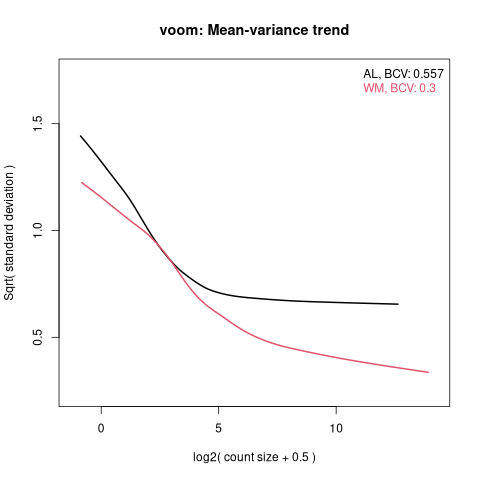

In [47]:
%%R
source("/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/voomByGroup.R")
y_vbg <- voomByGroup(x2,design = design_full, group = cd, plot = "combine")

In [48]:
%%R
fit <- lmFit(y_vbg, design_full)

In [49]:
%%R
contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

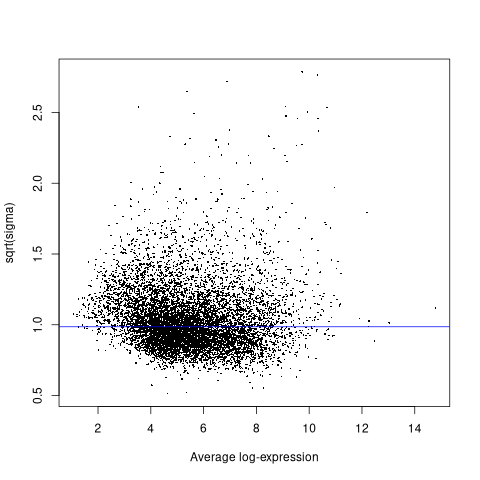

In [50]:
%%R
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [51]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 856
           logFC  AveExpr         t      P.Value    adj.P.Val          B
CSMD1   7.996117 2.852725  4.484138 2.166307e-04 2.705139e-03  0.4812237
TNS1    7.570656 3.927511  4.098270 5.385281e-04 5.236377e-03 -0.5666107
ZNF804A 7.449564 7.096842 10.557155 1.000569e-09 4.263332e-07 12.0860222
VIM     7.440749 4.059010  5.662113 1.413992e-05 4.058158e-04  2.1639022
NUPR1   7.100330 5.758526  7.276109 4.291797e-07 3.030485e-05  6.0135799
DIRC3   6.943295 6.477729  5.334251 2.987025e-05 6.993570e-04  2.2441368


In [52]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 742
               logFC  AveExpr         t      P.Value    adj.P.Val           B
AP003481.1 -7.784037 5.573891 -6.603239 1.769327e-06 8.328941e-05  3.95447473
AC008691.1 -6.128489 7.592862 -9.820923 3.473266e-09 1.030055e-06 11.01644238
HCG22      -5.967650 3.824271 -4.264323 3.638272e-04 3.957177e-03  0.04599766
RGS1       -5.391409 6.872854 -5.139395 4.681780e-05 9.509999e-04  2.14368702
RGS6       -5.311278 3.281565 -4.136086 4.925149e-04 4.890519e-03 -0.03771483
PLAT       -5.116879 2.949942 -4.916871 7.852116e-05 1.367421e-03  1.27002439


### Save output

In [53]:
%%R

head(tt)

               logFC  AveExpr         t      P.Value    adj.P.Val        B
ST6GALNAC3 -4.179549 9.301374 -13.87436 2.048924e-12 1.220784e-08 18.55944
NAV3       -3.619015 9.693441 -13.67270 2.744259e-12 1.220784e-08 18.26226
SERPINB9   -3.667594 6.308777 -12.16044 2.754428e-11 8.168715e-08 15.80128
AC008691.1 -6.166237 7.592861 -11.55120 7.420517e-11 1.650508e-07 14.65918
ADAM28     -1.993259 9.467792 -11.34430 1.048067e-10 1.864931e-07 14.68781
STARD13     3.581816 9.168734  10.70192 3.153193e-10 4.675660e-07 13.57237


In [54]:
%%R

# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/MG_EvA_WM_v_AL_vwqw_blocked.csv", row.names = FALSE, sep = ",", quote = FALSE)

In [55]:
%%R

head(tt_full)

            logFC   AveExpr         t      P.Value    adj.P.Val        B
ADAM28  -2.013952  9.467793 -15.33288 1.119062e-12 9.520282e-09 19.15301
MITF     2.719222  8.405525  14.81370 2.140111e-12 9.520282e-09 18.29728
PCNX2   -2.160226  8.754441 -13.46385 1.267472e-11 3.758901e-08 16.76360
STARD13  3.651350  9.168735  13.18272 1.869482e-11 3.760167e-08 16.36280
NAV3    -3.534516  9.693442 -13.09507 2.113166e-11 3.760167e-08 16.28343
DOCK4   -1.759257 12.478511 -12.88870 2.827178e-11 4.192234e-08 16.03731


In [56]:
%%R

# Add row names as a new column
tt_full$gene <- rownames(tt_full)

# Optionally reorder or select columns
tt_full <- tt_full[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt_full, file = "./files/MG_EvA_WM_v_AL_bygroup.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Dream analysis

In [57]:
%%R

library("variancePartition")
library("BiocParallel")

Loading required package: ggplot2
Loading required package: BiocParallel

Attaching package: ‘variancePartition’

The following object is masked from ‘package:limma’:

    topTable



In [58]:
%%R

options(ports=8889)

In [59]:
%%R

param <- SnowParam(4, "SOCK", progressbar = TRUE)

In [60]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [61]:
%%R

# Convert Group column to a factor
treatments$Group <- factor(treatments$Group)

# Check levels to confirm AL and WM exist
levels(treatments$Group)

[1] "AL" "WM"


In [62]:
%%R

form <- ~ Group + (1 | Donor)

In [64]:
%%R

vobjDream <- voomWithDreamWeights(x2, form, treatments)

In [65]:
%%R

fitmm <- dream(vobjDream, form, treatments)
fitmm <- eBayes(fitmm)

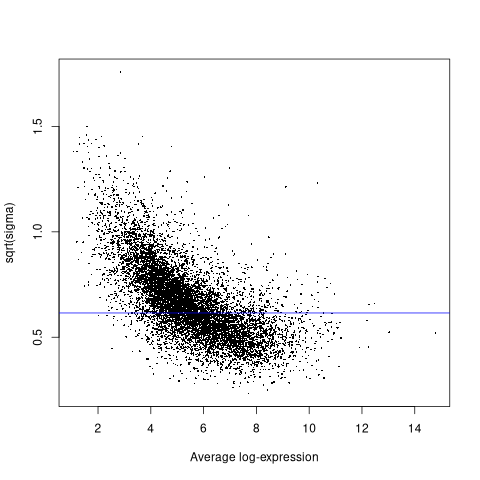

In [66]:
%%R

plotSA(fitmm, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [67]:
%%R

head(fitmm$design, 5)

                  (Intercept) GroupWM
Ind98-Sample2_WM            1       1
Ind107-Sample1_WM           1       1
Ind117-Sample1_WM           1       1
Ind121-Sample1_WM           1       1
Ind131-Sample1_WM           1       1


In [68]:
%%R

tt_dream <- topTable(fitmm, sort.by = "P", n = Inf)

Removing intercept from test coefficients


In [69]:
%%R
length(which(tt_dream$adj.P.Val < 0.05))

[1] 1947


In [111]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC <= 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1241
                 gene     logFC  AveExpr          t      P.Value    adj.P.Val
HS3ST2         HS3ST2 -6.976411 3.542495  -3.265752 3.350897e-03 2.096549e-02
TRHDE           TRHDE -6.810385 3.891787  -7.823502 5.926735e-08 5.581814e-06
AP002991.1 AP002991.1 -6.778642 4.184528 -10.113319 3.026139e-09 6.360449e-07
EYA2             EYA2 -6.773520 5.108346 -12.561164 7.125343e-12 7.046165e-09
GALNTL6       GALNTL6 -6.520834 3.690007  -4.341844 2.328273e-04 2.909360e-03
NUPR1           NUPR1 -6.517721 5.758526 -10.176100 4.626173e-10 1.646362e-07
                    B     z.std     gene.1
HS3ST2     -2.0972382 -2.933568     HS3ST2
TRHDE       5.5431862 -5.420998      TRHDE
AP002991.1 10.9220327 -5.930174 AP002991.1
EYA2        8.8594225 -6.855118       EYA2
GALNTL6     0.4865968 -3.680445    GALNTL6
NUPR1       8.1490091 -6.231287      NUPR1


In [108]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC >= -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 1049
                 gene      logFC  AveExpr         t     P.Value  adj.P.Val
MROH1           MROH1 -0.6948947 6.158129 -3.226236 0.005338688 0.02939252
AC087500.1 AC087500.1 -0.6873125 5.302441 -3.122991 0.006453848 0.03373671
DCAKD           DCAKD -0.6856735 5.075030 -3.490948 0.005861889 0.03141761
SNX30           SNX30 -0.6825149 7.609122 -3.241248 0.005041941 0.02829853
TMEM104       TMEM104 -0.6749416 4.883505 -3.003829 0.009602300 0.04541821
SZRD1           SZRD1 -0.6748755 4.985610 -3.049227 0.008468706 0.04110533
                   B     z.std     gene.1
MROH1      -2.661780 -2.785854      MROH1
AC087500.1 -2.865656 -2.723785 AC087500.1
DCAKD      -2.057764 -2.755409      DCAKD
SNX30      -2.632463 -2.804342      SNX30
TMEM104    -3.076748 -2.589831    TMEM104
SZRD1      -2.984587 -2.632789      SZRD1


In [72]:
%%R

# Add row names as a new column
tt_dream$gene <- rownames(tt_dream)

In [73]:
%%R
head(tt_dream)

               logFC  AveExpr         t      P.Value    adj.P.Val        B
ST6GALNAC3  3.607608 9.301374  14.95492 1.839725e-13 1.636803e-09 20.84642
MITF       -2.584601 8.405525 -14.12286 6.169291e-13 1.640748e-09 19.67965
TMEM156     2.251460 7.480863  14.02233 7.168029e-13 1.640748e-09 19.53083
ABCC4       2.225773 9.108282  13.78360 1.027183e-12 1.640748e-09 19.19841
SERPINB9    3.628969 6.308778  14.09847 1.046810e-12 1.640748e-09 14.11308
ARHGAP10   -5.802836 4.580765 -13.73465 1.106495e-12 1.640748e-09 18.29881
               z.std       gene
ST6GALNAC3  7.359955 ST6GALNAC3
MITF       -7.196688       MITF
TMEM156     7.176191    TMEM156
ABCC4       7.126815      ABCC4
SERPINB9    7.124208   SERPINB9
ARHGAP10   -7.116566   ARHGAP10


In [74]:
%%R

# Optionally reorder or select columns
tt_dream <- tt_dream[, c("gene", names(tt_dream)[1:8])]

# Write to CSV file
write.table(tt_dream, file = "./files/MG_EvA_WM_v_AL_dream.csv", row.names = FALSE, sep = ",", quote = FALSE)

## Dream with added variables

In [75]:
%%R
colnames(treatments)

[1] "Group"   "Donor"   "Sex"     "Age_cat" "Pmi_cat"


In [76]:
%%R

form <- ~ 0 + Group + Sex + Age_cat + Pmi_cat + (1 | Donor)

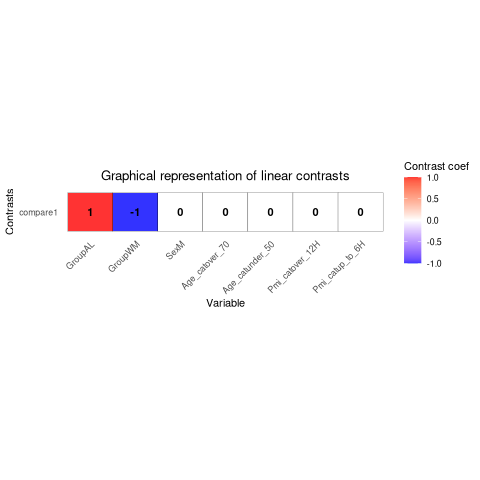

In [77]:
%%R

L <- makeContrastsDream(form, treatments,
  contrasts = c(
    compare1 = "GroupAL - GroupWM"
  )
)

# Visualize contrast matrix
plotContrasts(L)

In [78]:
%%R

vobjDream2 <- voomWithDreamWeights(x2, form, treatments)

In [79]:
%%R

# fit dream model with contrasts
fit_full <- dream(vobjDream2, form, treatments, L)
fit_full <- eBayes(fit_full)

# get names of available coefficients and contrasts for testing
colnames(fit_full)

[1] "compare1"        "GroupAL"         "GroupWM"         "SexM"           
[5] "Age_catover_70"  "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [80]:
%%R

tt_dream_full <- topTable(fit_full, coef="compare1", sort.by = "P", n = Inf)

In [81]:
%%R

length(which(tt_dream_full$adj.P.Val < 0.05))

[1] 937


In [82]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream_full[tt_dream_full$adj.P.Val < 0.05 & tt_dream_full$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 505
           logFC  AveExpr        t      P.Value    adj.P.Val          B
CSMD1   8.063715 2.852725 3.775399 1.321258e-03 0.0214168850 -1.0086329
ZNF804A 7.661389 7.096842 8.273031 3.604668e-07 0.0002508748  2.0218731
VIM     7.380736 4.059010 6.222614 6.681364e-06 0.0008830905  3.5210898
TNS1    7.207175 3.927511 6.400557 6.932285e-06 0.0008938629  0.3883503
NUPR1   7.199218 5.758526 6.555519 3.190166e-06 0.0006170196  2.6696112
EYA2    6.867659 5.108346 7.363363 8.277144e-07 0.0004045802  2.8236151
           z.std
CSMD1   3.211322
ZNF804A 5.088731
VIM     4.503595
TNS1    4.495757
NUPR1   4.658180
EYA2    4.928717


In [83]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream_full[tt_dream_full$adj.P.Val < 0.05 & tt_dream_full$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 417
               logFC  AveExpr         t      P.Value    adj.P.Val          B
AP003481.1 -7.684588 5.573891 -7.727392 2.037917e-06 0.0005036484  4.9154615
AC008691.1 -5.909673 7.592862 -7.312715 1.902155e-06 0.0005036484  1.0382332
HCG22      -5.861610 3.824271 -4.936218 2.107221e-04 0.0073648395 -0.7871417
RGS6       -5.350731 3.281565 -3.851053 1.308068e-03 0.0213931598 -1.3438721
RGS1       -5.278177 6.872854 -5.336487 4.317957e-05 0.0026599490 -0.2519615
RASGEF1C   -4.898453 8.557444 -5.758668 2.032126e-05 0.0016659210  1.9140158
               z.std
AP003481.1 -4.749628
AC008691.1 -4.763551
HCG22      -3.705803
RGS6       -3.214204
RGS1       -4.089773
RASGEF1C   -4.261331


### Variance partition plots

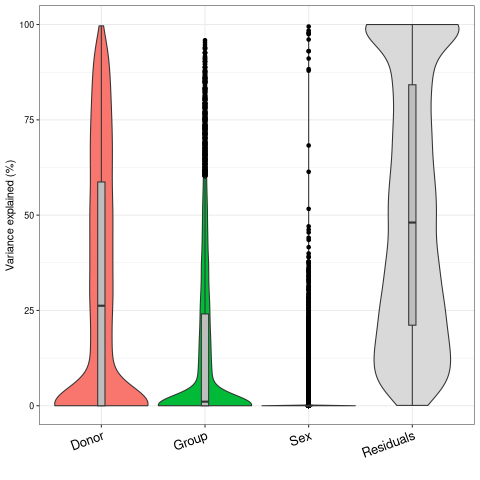

In [84]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In addition: Warning message:
In .fitExtractVarPartModel(exprObj, formula, data, REML = REML,  :
  Model failed for 1 responses.
  See errors with attr(., 'errors')


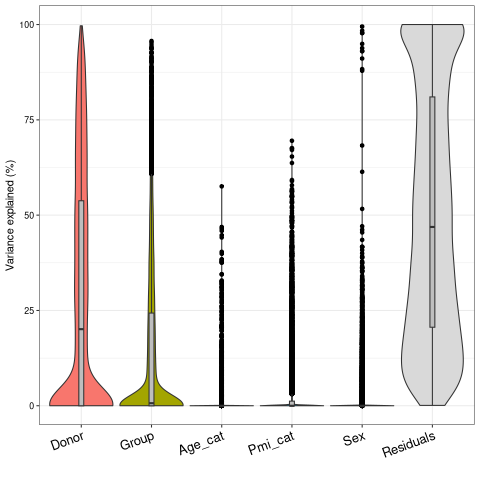

In [85]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Age_cat) + (1 | Pmi_cat) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [87]:
%%R
dim(tmp2)

[1] 8897    1


In [88]:
%%R
dim(fitmm)

[1] 8897    2


In [89]:
%%R
all(rownames(tmp2) == rownames(fitmm))

[1] TRUE


In [90]:
%%R
dim(vp)

[1] 8896    6


In [91]:
%%R
all(rownames(tmp2) == rownames(vp))

[1] FALSE


In addition: Warning message:
In rownames(tmp2) == rownames(vp) :
  longer object length is not a multiple of shorter object length


In [92]:
%%R
missing_rows <- setdiff(rownames(fitmm), rownames(vp))
print(missing_rows)

[1] "S100A6"


In [93]:
%%R

# Define the rows to remove
rows_to_remove <- c("S100A6")

# Remove them from tmp2
tmp2 <- tmp2[!(rownames(tmp2) %in% rows_to_remove), ]

# Remove them from fitmm
fitmm <- fitmm[!(rownames(fitmm) %in% rows_to_remove), ]

# Check dimensions again to confirm they match
dim(tmp2)

[1] 8896    1


Removing intercept from test coefficients


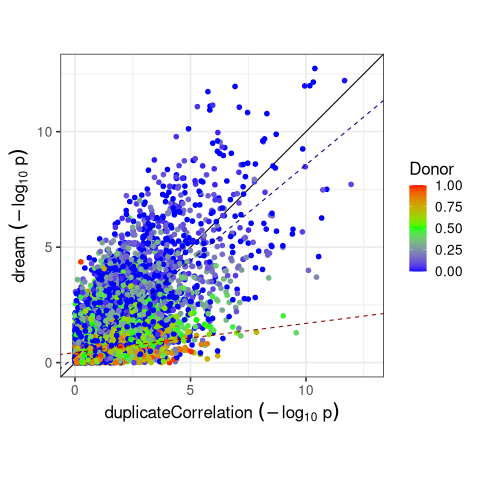

In [94]:
%%R

# Compare p-values and make plot
p1 <- topTable(tmp2, coef = "GroupAL - GroupWM", number = Inf, sort.by = "none")$P.Value
p2 <- topTable(fitmm, number = Inf, sort.by = "none")$P.Value

plotCompareP(p1, p2, vp$Donor, corfit2$consensus)

# Box plots of highly differentially expressed genes

In [95]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [96]:
%%R
library(reshape2)  # For transforming data from wide to long format
library(ggplot2)   # For plotting

# Step 1: Combine Expression and Treatment Data
# Convert the E matrix into a dataframe
expr_df <- as.data.frame(cpm)
expr_df$gene <- rownames(cpm)  # Add gene names as a column

head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL669831.5        23.066446          59.74511          38.08093
C1orf159          30.755262          52.27697          28.79290
SDF4              26.910854          26.88530          32.50811
UBE2J2            30.755262          50.78334          46.44016
ACAP3              7.688815          20.91079          13.93205
INTS11            11.533223          31.36618          29.72170
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL669831.5          33.68989         20.742556          12.03434
C1orf159            23.58292         11.724054          24.06869
SDF4                13.47595         28.859209          30.08586
UBE2J2              57.27281         28.859209          18.05152
ACAP3                0.00000          9.018503           0.00000
INTS11              26.95191         21.644406          30.08586
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL669831.5         55.688583    

In [97]:
%%R
colnames(expr_df)

 [1] "Ind98-Sample2_WM"  "Ind107-Sample1_WM" "Ind117-Sample1_WM"
 [4] "Ind121-Sample1_WM" "Ind131-Sample1_WM" "Ind133-Sample1_WM"
 [7] "Ind139-Sample1_WM" "Ind140-Sample1_WM" "Ind145-Sample1_WM"
[10] "Ind102-Sample1_AL" "Ind103-Sample1_AL" "Ind106-Sample1_AL"
[13] "Ind114-Sample1_AL" "Ind114-Sample2_AL" "Ind115-Sample1_AL"
[16] "Ind115-Sample2_AL" "Ind122-Sample1_AL" "Ind127-Sample1_AL"
[19] "Ind127-Sample3_AL" "Ind127-Sample4_AL" "Ind130-Sample1_AL"
[22] "Ind130-Sample2_AL" "gene"             


In [98]:
%%R
# Drop the "gene" column
expr_df <- expr_df[, !colnames(expr_df) %in% "gene"]

# Display the modified dataframe
head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL669831.5        23.066446          59.74511          38.08093
C1orf159          30.755262          52.27697          28.79290
SDF4              26.910854          26.88530          32.50811
UBE2J2            30.755262          50.78334          46.44016
ACAP3              7.688815          20.91079          13.93205
INTS11            11.533223          31.36618          29.72170
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL669831.5          33.68989         20.742556          12.03434
C1orf159            23.58292         11.724054          24.06869
SDF4                13.47595         28.859209          30.08586
UBE2J2              57.27281         28.859209          18.05152
ACAP3                0.00000          9.018503           0.00000
INTS11              26.95191         21.644406          30.08586
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL669831.5         55.688583    

In [99]:
%%R

# Convert design matrix to a dataframe and add sample IDs as rownames
design_df <- as.data.frame(y_vqw_full$design)
design_df$sample <- rownames(design_df)
design_df

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
Ind139-Sample1_WM       0       1    1              1               0
Ind140-Sample1_WM       0       1    0              1               0
Ind145-Sample1_WM       0       1    0              1               0
Ind102-Sample1_AL       1       0    1              0               0
Ind103-Sample1_AL       1       0    0              0               1
Ind106-Sample1_AL       1       0    1              0               0
Ind114-Sample1_AL       1       0    0              0               1
Ind114-Sample2_AL   

In [100]:
%%R

# Step 1: Rename the columns of expr_df to match the design information
colnames(expr_df) <- paste0("Sample", seq_len(ncol(expr_df) - 1))  # Adjust for gene column
expr_df$gene <- rownames(expr_df)

# Update design_df to have corresponding sample IDs
design_df$sample <- paste0("Sample", seq_len(nrow(design_df)))

# Step 2: Melt the expression data into a long format
expr_long <- melt(expr_df, id.vars = "gene", variable.name = "sample", value.name = "expression")

# Step 3: Merge expression data with treatment information
expr_treatment <- merge(expr_long, design_df, by = "sample")

In [101]:
%%R
head(expr_treatment)

   sample       gene expression GroupAL GroupWM SexM Age_catover_70
1 Sample1     ATXN10 326.774655       0       1    1              0
2 Sample1 MIRLET7BHG 130.709862       0       1    1              0
3 Sample1      PPARA  69.199339       0       1    1              0
4 Sample1      TTC38  23.066446       0       1    1              0
5 Sample1       TRMU  26.910854       0       1    1              0
6 Sample1     CELSR1   3.844408       0       1    1              0
  Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H
1               1               1               0
2               1               1               0
3               1               1               0
4               1               1               0
5               1               1               0
6               1               1               0


In [109]:
%%R

# Define the gene of interest
gene_of_interest <- "SPP1"  # Replace with the actual gene name

# Subset the dataframe to get the row corresponding to the gene
gene_info <- subset(tt_dream, gene == gene_of_interest)

# Print the gene information
print(gene_info)

     gene     logFC  AveExpr        t    P.Value  adj.P.Val         B    z.std
SPP1 SPP1 0.7562094 10.33845 2.437642 0.02602282 0.09194798 -4.222763 2.225871
     gene.1
SPP1   SPP1


In [103]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "SPP1")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

        sample gene expression GroupAL GroupWM SexM Age_catover_70
3186   Sample1 SPP1  1545.4519       0       1    1              0
12083 Sample10 SPP1   871.6808       1       0    1              0
20980 Sample11 SPP1  1207.7104       1       0    0              0
29878 Sample12 SPP1  1300.2433       1       0    1              0
38774 Sample13 SPP1   773.4311       1       0    0              0
44511 Sample14 SPP1   381.7552       1       0    0              0
      Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H treatment
3186                1               1               0        WM
12083               0               0               0        AL
20980               1               0               1        AL
29878               0               1               0        AL
38774               1               0               0        AL
44511               1               0               0        AL


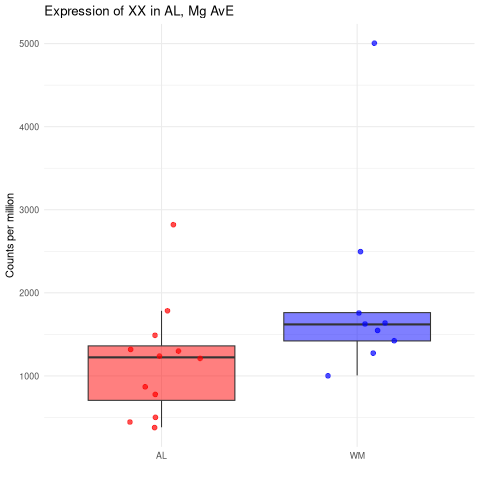

In [106]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvE",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

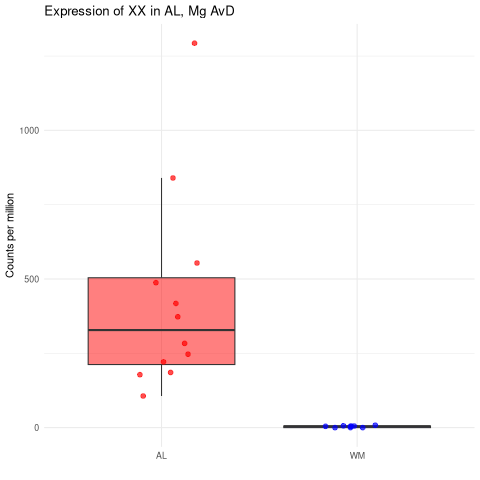

In [112]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "NUPR1")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")

ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvD",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Try to plot some genes to see if you belive results

In [ ]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
#from gprofiler import gprofiler

In [ ]:
from matplotlib import rcParams
from matplotlib import cm, colors

# Create a custom color map using 'PuRd' color map
colors2 = plt.cm.PuRd(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7, 0.8, 20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/figures_MG/'
sc.logging.print_header()

In [ ]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_MG_working.h5ad')
adata

In [ ]:
sc.tl.dendrogram(adata, 'lesion_type')
sc.pl.dendrogram(adata, 'lesion_type')

In [ ]:
# Specify the gene name you want to include in the filename
gene_name = 'MTRNR2L8'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

In [ ]:
# Specify the gene name you want to include in the filename
gene_name = 'PRDM11'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

# Do results overlap with LR pairs?

In [113]:
import liana as li

In [114]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [115]:
%R -o tt_dream

In [116]:
# Display the first few rows
tt_dream.head()

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,gene.1
ST6GALNAC3,ST6GALNAC3,3.607608,9.301374,14.954922,1.839725e-13,1.636803e-09,20.846418,7.359955,ST6GALNAC3
MITF,MITF,-2.584601,8.405525,-14.122856,6.169291e-13,1.640748e-09,19.679651,-7.196688,MITF
TMEM156,TMEM156,2.251460,7.480863,14.022326,7.168029e-13,1.640748e-09,19.530829,7.176191,TMEM156
ABCC4,ABCC4,2.225773,9.108282,13.783596,1.027183e-12,1.640748e-09,19.198405,7.126815,ABCC4
SERPINB9,SERPINB9,3.628969,6.308778,14.098475,1.046810e-12,1.640748e-09,14.113083,7.124208,SERPINB9


In [117]:
tt_dream.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
tt_dream.rename(columns={'P.Value': 'Pvalue'}, inplace=True)

In [118]:
# Move row names to a column called 'gene'
tt_dream['gene'] = tt_dream.index

# Reset the index so the gene names become part of the dataframe
tt_dream.reset_index(drop=True, inplace=True)

# Display the updated dataframe
tt_dream.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,ST6GALNAC3,3.607608,9.301374,14.954922,1.839725e-13,1.636803e-09,20.846418,7.359955,ST6GALNAC3
1,MITF,-2.584601,8.405525,-14.122856,6.169291e-13,1.640748e-09,19.679651,-7.196688,MITF
2,TMEM156,2.251460,7.480863,14.022326,7.168029e-13,1.640748e-09,19.530829,7.176191,TMEM156
3,ABCC4,2.225773,9.108282,13.783596,1.027183e-12,1.640748e-09,19.198405,7.126815,ABCC4
4,SERPINB9,3.628969,6.308778,14.098475,1.046810e-12,1.640748e-09,14.113083,7.124208,SERPINB9


In [119]:
sigs = tt_dream[(tt_dream.Padj < 0.05) & (abs(tt_dream.logFC) >= 1)]
sigs.shape

(1210, 9)

In [120]:
lr_pairs.shape

(4624, 2)

In [121]:
sigs.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,ST6GALNAC3,3.607608,9.301374,14.954922,1.839725e-13,1.636803e-09,20.846418,7.359955,ST6GALNAC3
1,MITF,-2.584601,8.405525,-14.122856,6.169291e-13,1.640748e-09,19.679651,-7.196688,MITF
2,TMEM156,2.251460,7.480863,14.022326,7.168029e-13,1.640748e-09,19.530829,7.176191,TMEM156
3,ABCC4,2.225773,9.108282,13.783596,1.027183e-12,1.640748e-09,19.198405,7.126815,ABCC4
4,SERPINB9,3.628969,6.308778,14.098475,1.046810e-12,1.640748e-09,14.113083,7.124208,SERPINB9


In [122]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
14,HRH1,-3.543006,4.651863,-11.165820,7.544284e-11,4.474766e-08,14.939105,-6.509417,HRH1
19,PLXNC1,-4.585865,5.536396,-10.606550,2.501961e-10,1.069934e-07,10.145800,-6.326863,PLXNC1
21,GPNMB,-5.097024,7.143696,-11.251138,2.732018e-10,1.092641e-07,7.960990,-6.313269,GPNMB
27,ITGAM,1.785053,6.984062,9.951420,7.095998e-10,2.254753e-07,12.759252,6.163933,ITGAM
38,CADM1,-3.677030,7.134390,-9.280006,2.644861e-09,6.033675e-07,11.484795,-5.952247,CADM1
...,...,...,...,...,...,...,...,...,...
1881,TNFSF14,-2.090099,2.539341,-2.889201,9.626131e-03,4.547227e-02,-3.000107,-2.588978,TNFSF14
1899,ARF6,-1.428229,3.241121,-2.908663,9.865031e-03,4.619431e-02,-3.042255,-2.580525,ARF6
1908,MERTK,-1.011809,8.708926,-2.886899,1.013408e-02,4.721437e-02,-3.077478,-2.571220,MERTK
1942,TRAF3,-1.043073,7.691887,-2.828750,1.086491e-02,4.975045e-02,-3.107028,-2.547014,TRAF3


In [123]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
14,HRH1,-3.543006,negative
19,PLXNC1,-4.585865,negative
21,GPNMB,-5.097024,negative
27,ITGAM,1.785053,positive
38,CADM1,-3.677030,negative
...,...,...,...
1881,TNFSF14,-2.090099,negative
1899,ARF6,-1.428229,negative
1908,MERTK,-1.011809,negative
1942,TRAF3,-1.043073,negative


In [124]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 34


,ligand,receptor,logFC_ligand,logFC_receptor
23,PLAT,ITGAM,4.121954,1.785053
6,ADAM28,ITGA4,1.589985,-3.419644
30,ENTPD1,ADORA1,1.491532,-2.671909
10,IGF1,IGF2R,1.438307,-1.958725
4,SELPLG,ITGAM,1.371262,1.785053
5,SELPLG,SELL,1.371262,1.505404
3,ST6GAL1,CD22,1.370807,-3.310750
0,ADAM10,CD44,1.012714,-4.482151
1,ADAM10,NOTCH2,1.012714,-1.262869
26,ADAM10,TSPAN5,1.012714,1.572209


In [125]:
sigs_up = tt_dream[(tt_dream.Padj < 0.05) & (tt_dream.logFC <= -1)]
sigs_up.shape

(739, 9)

In [126]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 16


,ligand,receptor,logFC_ligand,logFC_receptor
14,PSAP,CELSR1,-1.153901,-2.870160
13,PKM,CD44,-1.192701,-4.482151
7,HGF,ST14,-1.561413,-3.020606
6,HGF,SDC2,-1.561413,-3.468615
5,HGF,CD44,-1.561413,-4.482151
4,HGF,NRP1,-1.561413,-1.599469
2,APOE,SDC2,-1.896274,-3.468615
3,APOE,SCARB1,-1.896274,-1.294590
11,APOE,ABCA1,-1.896274,-3.006473
0,TNFSF14,TNFRSF14,-2.090099,-3.037222


In [ ]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_pairs_MG_active_AL_CAL_DESIGN_NEW.csv', sep='\t', index=False)